In [3]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler



In [4]:
import torch
import torch.nn as nn

class SigmaCellRLTV(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SigmaCellRLTV, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Time-varying parameter network for dynamic GARCH parameters
        self.tv_network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2 * hidden_size)
        )

        # Residual RNN layer
        self.rnn = nn.GRUCell(input_size, hidden_size)

        # Output layer for volatility prediction
        self.output = nn.Linear(hidden_size, 1)

        # Activation functions
        self.phi = nn.ReLU()
        self.phi_o = nn.Identity()  # Remove activation to allow signed outputs

        # Initialize weights
        for layer in self.tv_network:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)
        nn.init.kaiming_normal_(self.output.weight, nonlinearity='relu')
        nn.init.zeros_(self.output.bias)

    def forward(self, x, h_prev, sigma_prev):
        x = x.view(1, -1)  # Ensure input shape compatibility

        # Time-varying parameters
        w_t = self.tv_network(x)
        W_s_t, W_r_t = torch.split(w_t, self.hidden_size, dim=-1)

        # Residual calculation
        h_t = self.rnn(x, h_prev)  # Recurrent update
        G_h = self.phi(h_t)  # Function mapping ht for residual

        # Error calculation (ϵt)
        x_tilde = x - G_h

        # Variance evolution using σ˜2t equation
        sigma_tilde = self.phi(sigma_prev * W_s_t + x_tilde**2 * W_r_t)
        sigma_tilde = torch.clamp(sigma_tilde, min=1e-6, max=1e6)  # Avoid extreme values

        # Conditional volatility output
        sigma = self.phi_o(self.output(sigma_tilde))

        return sigma, h_t, sigma_tilde


In [5]:
def train_sigma_cell_rltv(model, train_scaled, test_scaled, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()  # Training mode
        h = torch.randn(1, model.hidden_size)
        sigma = torch.ones(1, 1)
        total_train_loss = 0

        # Train on training data
        for t in range(len(train_scaled) - 1):
            optimizer.zero_grad()
            x_t = torch.tensor(train_scaled[t], dtype=torch.float32).view(1, 1)
            y_t = torch.tensor(train_scaled[t+1], dtype=torch.float32).view(1, 1)

            sigma_pred, h, sigma = model(x_t, h, sigma)
            loss = criterion(sigma_pred, y_t)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_train_loss += loss.item()
            h = h.detach()
            sigma = sigma.detach()

        avg_train_loss = total_train_loss / (len(train_scaled) - 1)
        train_losses.append(avg_train_loss)

        # Evaluate on validation/test data
        model.eval()  # Evaluation mode
        total_val_loss = 0
        with torch.no_grad():
            h_val = torch.randn(1, model.hidden_size)
            sigma_val = torch.ones(1, 1)

            for t in range(len(test_scaled) - 1):
                x_t = torch.tensor(test_scaled[t], dtype=torch.float32).view(1, 1)
                y_t = torch.tensor(test_scaled[t+1], dtype=torch.float32).view(1, 1)
                sigma_pred, h_val, sigma_val = model(x_t, h_val, sigma_val)
                loss = criterion(sigma_pred, y_t)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / (len(test_scaled) - 1)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        scheduler.step()

    return train_losses, val_losses

In [6]:
def predict_vix(model, data_scaled, scaler, forecast_horizon=0):
    model.eval()
    with torch.no_grad():
        h = torch.randn(1, model.hidden_size)
        sigma = torch.ones(1, 1)
        predictions_scaled = []

        # Predict for all input data
        for t in range(len(data_scaled)):
            x_t = torch.tensor(data_scaled[t], dtype=torch.float32).view(1, 1)
            sigma_pred, h, sigma = model(x_t, h, sigma)
            predictions_scaled.append(sigma_pred.item())

        # Optional future forecasts (set forecast_horizon=0 to disable)
        last_x = x_t
        for _ in range(forecast_horizon):
            sigma_pred, h, sigma = model(last_x, h, sigma)
            predictions_scaled.append(sigma_pred.item())
            last_x = torch.tensor([sigma_pred.item()], dtype=torch.float32).view(1, 1)

        # Inverse transform predictions to original scale
        predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1)).flatten()
        return predictions

In [22]:
# Download VIX data using yfinance
vix = yf.download('^VIX', start='2019-01-01', end='2025-02-05')
vix_data = vix['Close'].values


# Check for NaN or Inf values
if np.isnan(vix_data).any() or np.isinf(vix_data).any():
    raise ValueError("Data contains NaN or Inf values!")


# Split data
train_data = vix_data[:-401]
test_data = vix_data[-399:]

# Scale data using a single scaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()  # Fit on train
test_scaled = scaler.transform(test_data.reshape(-1, 1)).flatten()         # Transform test
full_scaled = np.concatenate([train_scaled, test_scaled])                   # Full dataset (scaled)


[*********************100%***********************]  1 of 1 completed


In [23]:


# Train on scaled training data
model = SigmaCellRLTV(input_size=1, hidden_size=32)
# Train the model and get losses
train_losses, val_losses = train_sigma_cell_rltv(
    model, train_scaled, test_scaled, epochs=35, lr=0.0001
)


Epoch 1/35, Train Loss: 5089316525.6124, Val Loss: 0.0024
Epoch 2/35, Train Loss: 2568736039.8171, Val Loss: 0.0035
Epoch 3/35, Train Loss: 3006619.3458, Val Loss: 0.0020
Epoch 4/35, Train Loss: 392.5940, Val Loss: 0.0011
Epoch 5/35, Train Loss: 4.4137, Val Loss: 0.0007
Epoch 6/35, Train Loss: 0.3900, Val Loss: 0.0006
Epoch 7/35, Train Loss: 0.0377, Val Loss: 0.0005
Epoch 8/35, Train Loss: 0.0060, Val Loss: 0.0005
Epoch 9/35, Train Loss: 0.0053, Val Loss: 0.0005
Epoch 10/35, Train Loss: 0.1125, Val Loss: 0.0005
Epoch 11/35, Train Loss: 0.0068, Val Loss: 0.0005
Epoch 12/35, Train Loss: 0.0066, Val Loss: 0.0005
Epoch 13/35, Train Loss: 0.0048, Val Loss: 0.0005
Epoch 14/35, Train Loss: 0.0054, Val Loss: 0.0005
Epoch 15/35, Train Loss: 0.0029, Val Loss: 0.0005
Epoch 16/35, Train Loss: 0.0046, Val Loss: 0.0005
Epoch 17/35, Train Loss: 0.0026, Val Loss: 0.0005
Epoch 18/35, Train Loss: 0.0031, Val Loss: 0.0005
Epoch 19/35, Train Loss: 0.0023, Val Loss: 0.0005
Epoch 20/35, Train Loss: 0.0026, 

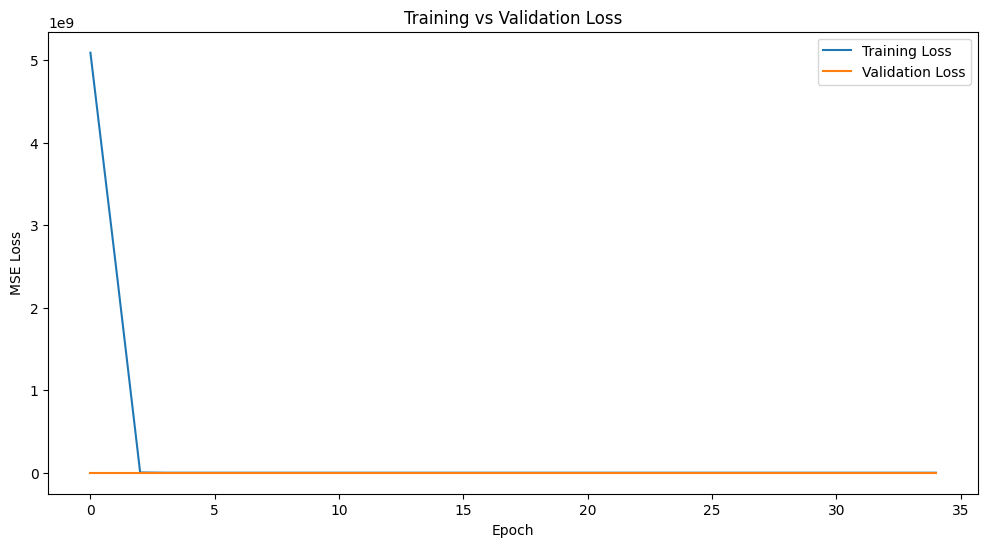

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


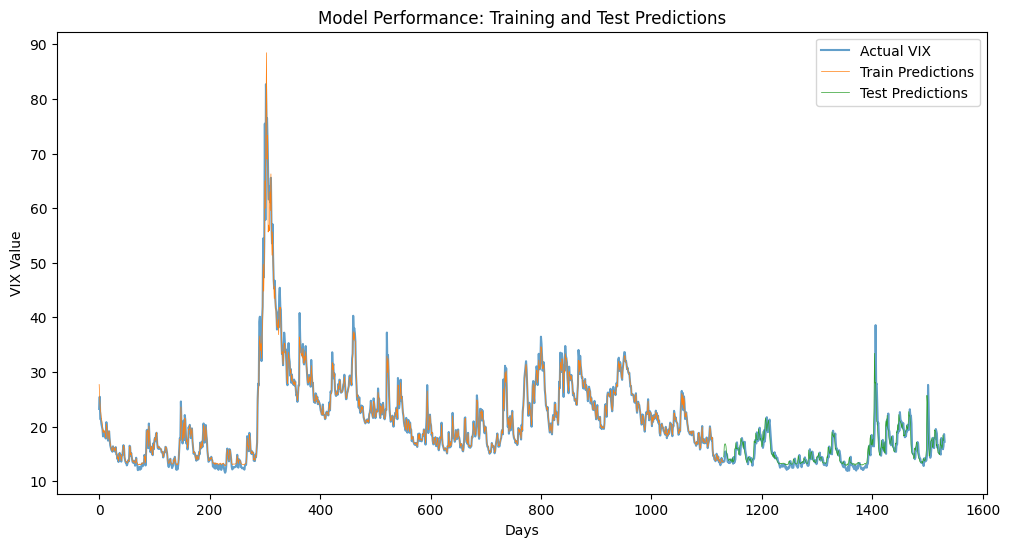

In [25]:
# Predict on training and test data
train_pred = predict_vix(model, train_scaled, scaler, forecast_horizon=0)
test_pred = predict_vix(model, test_scaled, scaler, forecast_horizon=0)

# Plot all predictions
plt.figure(figsize=(12, 6))
plt.plot(vix_data, label='Actual VIX', alpha=0.7)
plt.plot(range(len(train_pred)), train_pred, label='Train Predictions', linewidth=0.5)
plt.plot(range(len(train_data), len(train_data)+len(test_pred)), test_pred, label='Test Predictions',linewidth=0.5)
plt.title('Model Performance: Training and Test Predictions')
plt.xlabel('Days')
plt.ylabel('VIX Value')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import mean_absolute_error, r2_score

# Inverse-transform scaled data to original scale
train_actual = scaler.inverse_transform(train_scaled.reshape(-1, 1)).flatten()
test_actual = scaler.inverse_transform(test_scaled.reshape(-1, 1)).flatten()

# Training metrics
train_mae = mean_absolute_error(train_actual[1:], train_pred[:-1])  # Align timesteps
train_r2 = r2_score(train_actual[1:], train_pred[:-1])

# Test metrics
test_mae = mean_absolute_error(test_actual[1:], test_pred[:-1])
test_r2 = r2_score(test_actual[1:], test_pred[:-1])

print(f"Training MAE: {train_mae:.2f}, R²: {train_r2:.2f}")
print(f"Test MAE: {test_mae:.2f}, R²: {test_r2:.2f}")

Training MAE: 1.33, R²: 0.93
Test MAE: 0.90, R²: 0.74


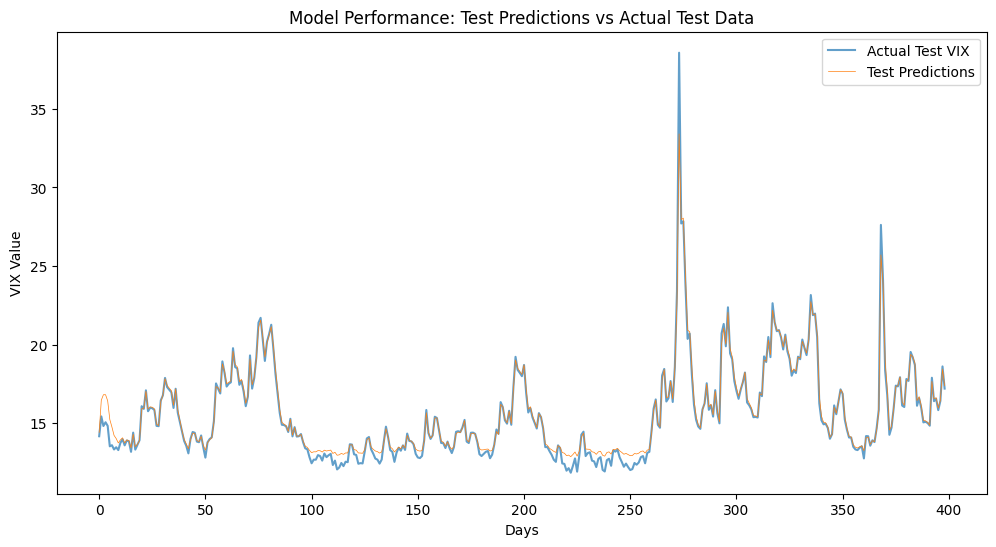

In [27]:
# Plot only test data vs predicted values
plt.figure(figsize=(12, 6))

# Plot the actual VIX values for the test set
plt.plot(range(len(test_data)), test_data, label='Actual Test VIX', alpha=0.7)

# Plot the predicted VIX values for the test set
plt.plot(range(len(test_data)), test_pred, label='Test Predictions', linewidth=0.5)

plt.title('Model Performance: Test Predictions vs Actual Test Data')
plt.xlabel('Days')
plt.ylabel('VIX Value')
plt.legend()
plt.show()
